In [1]:
import torch
from cibsde import nn, utils
from matplotlib import cm
import matplotlib.pyplot as plt
device = torch.device('cuda:0')

In [2]:
dx = 1
t = torch.tensor(1.,device=device)
D = torch.tensor([0.1],device=device)
N = 100
batch = 512
epoch = 10**4
lr = 1e-3

def data_gen(batch):
    u1 = torch.rand([batch],device=device)
    u2 = torch.rand([batch],device=device)
    phi = 2 * torch.pi * u1
    theta = torch.arccos(1 - 2 * u2)
    x = torch.sin(theta) * torch.cos(phi)
    y = torch.sin(theta) * torch.sin(phi)
    z = torch.cos(theta)
    return torch.stack([x,y,z],dim=1)

def pc(i,x):
    x_polar = utils.polar_corr(x)
    return (x_polar[:,:1]>torch.pi/4)*(x_polar[:,:1]<torch.pi*3/4)/torch.sin(x_polar[:,:1])

def refb(x):
    return x, x, torch.zeros(batch,device=device).bool()

def hitb(x):
    return torch.zeros(batch,device=device).bool()

def f(t,xt,p):
    return torch.zeros([batch,1],device=device)

models = nn.SphereIBSDE(
    dx = dx,
    t = t,
    f = f,
    D = D,
    pc = pc,
    data_gen = data_gen,
    N = N,
    refb = refb,
    hitb = hitb,
    param = False
).to(device)

In [3]:
train_params = {
    'epoch': epoch,
    'batch': batch,
    'lr': lr
}

loss_values = nn.train(
    models,
    train_params
)

10000/10000|##################################################|6117.75s  [Loss: 3.063840e-02] 
Training has been completed.


In [4]:
shape = [101,201]
theta = torch.linspace(0,torch.pi,shape[0],device=device)
phi = torch.linspace(0,torch.pi*2,shape[1],device=device)
theta,phi = torch.meshgrid(theta,phi,indexing='ij')
x_polar = torch.stack([theta.reshape(shape[0]*shape[1]),phi.reshape(shape[0]*shape[1])],dim=1)
x = utils.euclid_corr(x_polar)
y = models.p(x).detach().cpu().reshape(shape)

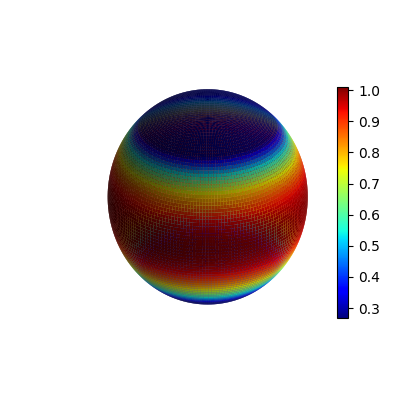

In [5]:
x = x.reshape([101,201,3]).cpu()
fig = plt.figure(figsize=(5,5), facecolor='white')
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x[:,:,0], x[:,:,1], x[:,:,2], facecolors=cm.jet(((y-y.min())/(y.max()-y.min())*2-1)), 
                       rstride=1, cstride=1, linewidth=0)
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(y)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, pad=-0.15, aspect=20)
ax.set_box_aspect([1, 1, 1])
ax.set_axis_off()
plt.show()